# 4. 特征提取与空间分析

利用预训练的深度学习模型自动从图像瓦片中提取有意义的特征，然后使用标准的聚类工具对这些特征进行聚类和可视化。

整个过程分为三个步骤：
1. 分块
2. 特征提取
3. 下游任务分析

In [1]:
from wsidata import open_wsi
import lazyslide as zs

import matplotlib.pyplot as plt

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteb

加载一个 GTEx 小肠切片作为示例：

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


WSI: ../data/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /home/zql/code/lazy_slide/data/GTEX-11DXX-1626.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (19038, 4) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      └── 'plip_tiles': AnnData (19038, 512)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)
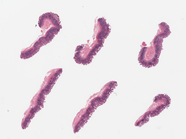

In [2]:
wsi = open_wsi("../data/GTEX-11DXX-1626.svs")
wsi

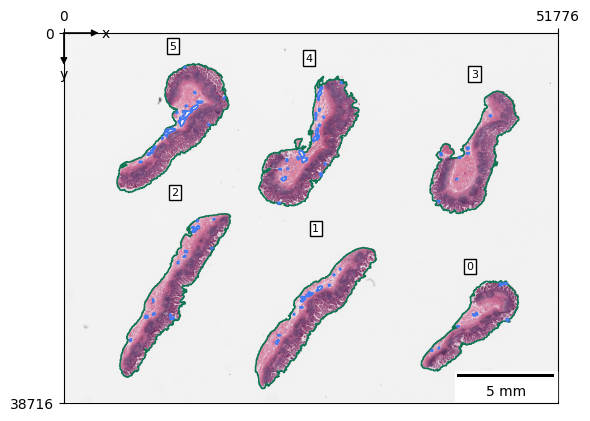

In [3]:
zs.pl.tissue(wsi)

In [5]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 128)

## 4.1 形态学特征提取

特征提取是将图像转换为数值表示，该表示包含不同的形态特征。通常，这是通过将瓦片输入到视觉模型中完成的。

LazySlide 支持自动混合精度推理，这可能减少内存使用并具有更快的推理速度，尝试 amp=True 。由于正在处理一个具有微小瓦片尺寸的大幻灯片，这可能需要 10 分钟才能完成（MacBook M3 Max）。

In [9]:
zs.tl.feature_extraction(wsi, "plip", amp=True, model_path="../models/plip")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

WSI: ../data/GTEX-11DXX-1626.svs
Reader: openslide
Dimensions: 38717×51791 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1118, 1495)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (19038, 3) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
└── Tables
      └── 'plip_tiles': AnnData (19038, 512)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)
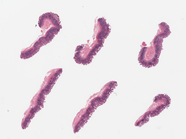

In [11]:
wsi

In [12]:
wsi['plip_tiles']

AnnData object with n_obs × n_vars = 19038 × 512
    obs: 'tile_id', 'library_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide'

In [14]:
wsi['plip_tiles'][0]

View of AnnData object with n_obs × n_vars = 1 × 512
    obs: 'tile_id', 'library_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide'

---

## 4.2 特征聚合

要对整个数据集进行分析，通常的方法是将特征聚合成一个 1D 向量，以便能够表示整个切片。默认情况下，应用的是均值池化。稍后将介绍更高级的切片编码器。

In [10]:
zs.tl.feature_aggregation(wsi, feature_key="plip")

可以使用 fetch 访问器获取特定特征。这将返回 anndata 的一个副本。

In [16]:
wsi.fetch.features_anndata("plip")

AnnData object with n_obs × n_vars = 19038 × 512
    obs: 'tile_id', 'tissue_id'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'
    varm: 'agg_slide'

---

## 4.3 特征空间检验

通过 PLIP 提取的图像瓦片中获取深度学习特征数据，进行预处理，然后执行标准分析工作流程以识别相似的瓦片组（聚类）。可以使用 UMAP 可视化瓦片空间。颜色代表通过在瓦片邻域图上计算 Leiden 聚类找到的不同簇。

In [21]:
!uv pip install scanpy
!uv pip install igraph

Using Python 3.12.11 environment at: /home/zql/code/lazy_slide/.venv
Audited 1 package in 12ms
Using Python 3.12.11 environment at: /home/zql/code/lazy_slide/.venv
Resolved 2 packages in 925ms                                         
⠙ Preparing packages... (0/2)                                                   
⠙ Preparing packages... (0/2)--------------     0 B/10.52 KiB           
⠙ Preparing packages... (0/2)---------- 10.52 KiB/10.52 KiB         
⠙ Preparing packages... (0/2)---------- 10.52 KiB/10.52 KiB         
texttable            ------------------------------ 10.52 KiB/10.52 KiB
⠙ Preparing packages... (0/2)--------------     0 B/5.42 MiB            
texttable            ------------------------------ 10.52 KiB/10.52 KiB
⠙ Preparing packages... (0/2)--------------     0 B/5.42 MiB            
⠙ Preparing packages... (0/2)--------------     0 B/5.42 MiB            
⠙ Preparing packages... (0/2)-------------- 16.00 KiB/5.42 MiB          
⠙ Preparing packages... (0/2)---------

In [22]:
import scanpy as sc

adata = wsi["plip_tiles"]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", resolution=0.2)

- 识别组织区域：不同簇可能对应不同的组织类型或形态
- 发现空间模式：相似特征的瓦片在空间上可能聚集
- 质量评估：异常瓦片可能形成独立簇

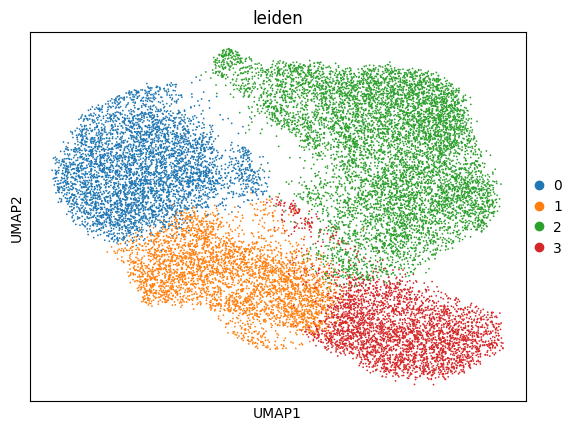

In [23]:
sc.pl.umap(adata, color="leiden")

In [24]:
sc.tl.rank_genes_groups(adata, groupby="leiden")

features = set()
for i in adata.obs["leiden"].unique():
    names = sc.get.rank_genes_groups_df(adata, i).names
    features.update(list(names[0:10]) + list(names[-10:]))
features = list(features)

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [26]:
!uv pip install marsilea

Using Python 3.12.11 environment at: /home/zql/code/lazy_slide/.venv
Resolved 20 packages in 1.29s                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/82.99 KiB           
⠙ Preparing packages... (0/1)-------------- 16.00 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)-------------- 32.00 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)-------------- 43.02 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)m------------- 45.79 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)2m------------ 48.00 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)----------- 50.77 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)---------- 56.31 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)---------- 61.86 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)---------- 67.41 KiB/82.99 KiB         
⠙ Preparing packages... (0/1)---------- 78.51 KiB/82.99 KiB      

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1167: RuntimeWarning: overflow encountered in divide
  rel_diff = xp.max(xp.abs(a_zero_mean), axis=axis,


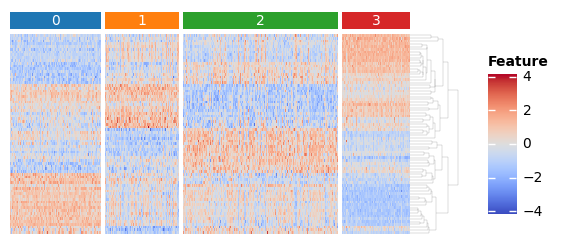

In [27]:
import marsilea as ma
import marsilea.plotter as mp
from scipy.stats import zscore

key = "leiden"
h = ma.Heatmap(zscore(adata[:, features].X.T), height=2, width=4, label="Feature")
order = sorted(adata.obs[key].unique())
h.group_cols(adata.obs[key], order=order)
h.add_top(mp.Chunk(order, fill_colors=adata.uns[f"{key}_colors"], padding=2), pad=0.05)
h.add_dendrogram("right", method="average", linewidth=0.1)
h.add_legends()
h.render()

---

## 4.4 空间域识别

基于基础模型特征的中子聚类已经能够很好地恢复组织的空间域。然而，这种聚类算法是基于每个瓦片形态特征的邻近性，但它并未考虑实际的空间信息。

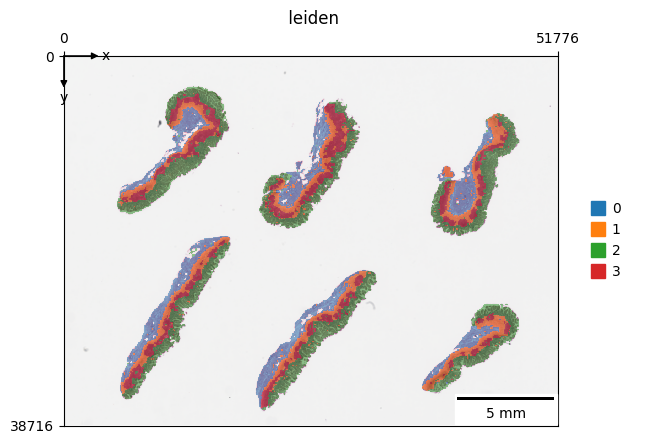

In [29]:
zs.pl.tiles(
    wsi,
    feature_key="plip",
    color="leiden",
    alpha=0.5,
    palette=adata.uns[f"{key}_colors"],
    show_contours=False,
)

In [30]:
zs.tl.spatial_domain(wsi, feature_key="plip", resolution=0.2)

In [31]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path: ../data/GTEX-11DXX-1626.zarr         


---

## 4.5 文本特征提取

除了从视觉模型中提取形态特征外，还可以运行多模态来提取文本特征。



In [4]:
terms = ["mucosa", "submucosa", "musclaris", "lymphocyte"]

In [6]:
embeddings = zs.tl.text_embedding(terms, model="plip", model_path="../models/plip")
zs.tl.text_image_similarity(wsi, embeddings, model="plip", softmax=True)

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/lazyslide/models/multimodal/plip.py:24: UserWarning: As from v0.8.2, Normalization will not be applied to image embedding of PLIP model anymore.A `normalize=True` argument is added to the `text_image_similarity` method.If you only use the image embedding for text image similarity, you can safely ignore this warning.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/lazyslide/tools/_text_annotate.py:176: UserWarning: As of v0.8.2, the image embedding from image text model is not normalized after feature extraction by default. The normalization is applied here (text_image_similarity

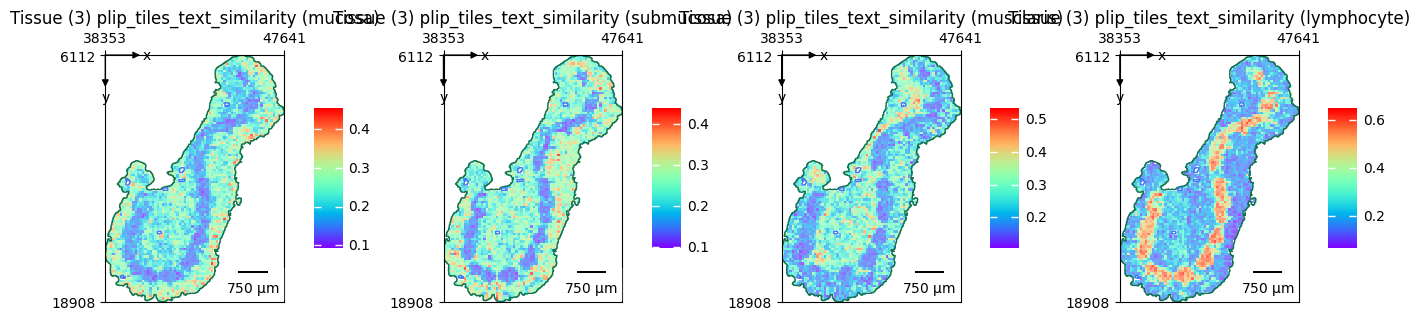

In [7]:
zs.pl.tiles(
    wsi,
    feature_key="plip_tiles_text_similarity",
    color=terms,
    cmap="rainbow",
    show_image=False,
    tissue_id=3,
    alpha=0.7,
)

"mucosa"（黏膜）相似度
- 相似度范围：0.1-0.4
- 模式：整体相似度较低，中心略高
- 含义：该区域黏膜特征不明显

"submucosa"（黏膜下层）相似度
- 相似度范围：0.1-0.4
- 模式：与黏膜类似，整体相似度较低
- 含义：黏膜下层特征不明显

"muscularis"（肌层）相似度
- 相似度范围：0.2-0.5
- 模式：中央和左下出现带状高相似度区域（橙红色）
- 含义：这些区域可能包含肌层组织

"lymphocyte"（淋巴细胞）相似度
- 相似度范围：0.2-0.6
- 模式：多个局部热点（亮红/橙色），呈小簇状分布
- 含义：这些热点可能对应淋巴细胞聚集或浸润区域